# Large Language Models. Homework 6.

Student: Georgy Andryushchenko

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-beryvg0i
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-beryvg0i
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

## Task 1: Loading the Model

Load the CLIP model and preprocessing utilities. Ensure that the model is set
to evaluation mode and moved to the GPU if available.


In [3]:
import torch
import clip

# Check if a GPU is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model and the preprocessing utilities
model, preprocess = clip.load("ViT-B/32", device=device)

# Set the model to evaluation mode
model.eval()

device


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 107MiB/s]


'cuda'

## Task 2: Preparing Images and Text Descriptions

1. Import the necessary libraries for handling images and plotting.



In [12]:
# Import necessary libraries
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
from skimage import data
import seaborn as sns

# Ensure the notebook displays plots inline
%matplotlib inline


2. Create a dictionary of image descriptions to match with corresponding
images from the skimage library.


In [5]:
# Dictionary of image descriptions and corresponding skimage data functions
image_descriptions = {
    "Astronaut": data.astronaut,
    "Coffee": data.coffee,
    "Camera": data.camera,
    "Checkerboard": data.checkerboard,
    "Horse": data.horse,
    "Moon": data.moon,
    "Clock": data.clock,
    "Rocket": data.rocket,
}


3. Load and preprocess the images, displaying each image along with its
description.

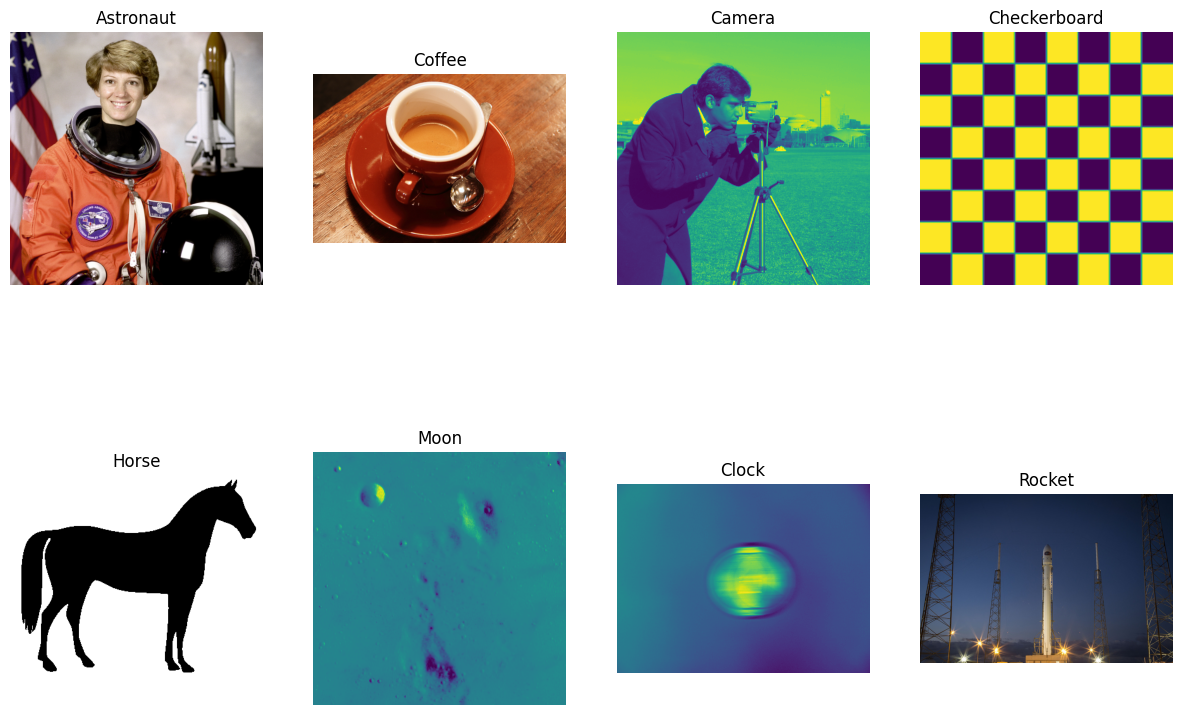

In [6]:
# Function to display images with descriptions
def display_images_with_descriptions(image_descriptions):
    plt.figure(figsize=(15, 10))

    for i, (description, load_image) in enumerate(image_descriptions.items()):
        # Load and preprocess the image
        image = Image.fromarray(load_image())
        preprocessed_image = preprocess(image).unsqueeze(0).to(device)

        # Display the image
        plt.subplot(2, 4, i+1)
        plt.imshow(image)
        plt.title(description)
        plt.axis('off')

    plt.show()

# Display the images with their descriptions
display_images_with_descriptions(image_descriptions)


## Task 3: Encoding Images and Texts

Use the CLIP model to encode the images and texts into feature vectors.


In [14]:
# Load and preprocess the images
images = []
preprocessed_images = []

for description, load_image in image_descriptions.items():
    image = Image.fromarray(load_image())
    images.append((description, image))
    preprocessed_image = preprocess(image).unsqueeze(0).to(device)
    preprocessed_images.append(preprocessed_image)

# Concatenate all preprocessed images into a single tensor
preprocessed_images_tensor = torch.cat(preprocessed_images, dim=0)

# Encode the images into feature vectors
with torch.no_grad():
    image_features = model.encode_image(preprocessed_images_tensor)

In [15]:
image_features

tensor([[ 0.3172,  0.3046, -0.1547,  ..., -0.1096, -0.2205,  0.1321],
        [ 0.1388,  0.5618, -0.1767,  ...,  0.6280,  0.1091,  0.0813],
        [-0.0015, -0.0935,  0.0244,  ...,  0.2347, -0.2746,  0.2865],
        ...,
        [-0.1925, -0.3405,  0.5381,  ..., -0.0732,  0.2042, -0.2494],
        [-0.0711,  0.2138,  0.2050,  ...,  0.1675,  0.2818,  0.0017],
        [ 0.0749,  0.2103,  0.0687,  ...,  0.0163, -0.2115, -0.5748]])

In [16]:
# Encode the texts into feature vectors
text_descriptions = list(image_descriptions.keys())
text_tokens = clip.tokenize(text_descriptions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)

In [17]:
text_features

tensor([[ 0.0093,  0.0229, -0.0465,  ..., -0.0553, -0.0637, -0.0163],
        [ 0.1593, -0.3300, -0.0572,  ...,  0.1351, -0.3374,  0.0376],
        [ 0.0667, -0.1396, -0.3371,  ..., -0.5031,  0.2013, -0.1267],
        ...,
        [-0.2130, -0.2522,  0.1526,  ..., -0.3402, -0.1576,  0.4014],
        [-0.0086, -0.0976, -0.2726,  ..., -0.4183, -0.1001, -0.1566],
        [ 0.1666, -0.0631,  0.1757,  ..., -0.2957, -0.2948, -0.0113]])

## Task 4: Calculating Similarity

Compute the cosine similarity between the image and text features and then
Display the similarity matrix between text and images as a heatmap.

Note: Do not forget to normalize both text and images before computing
the similarity

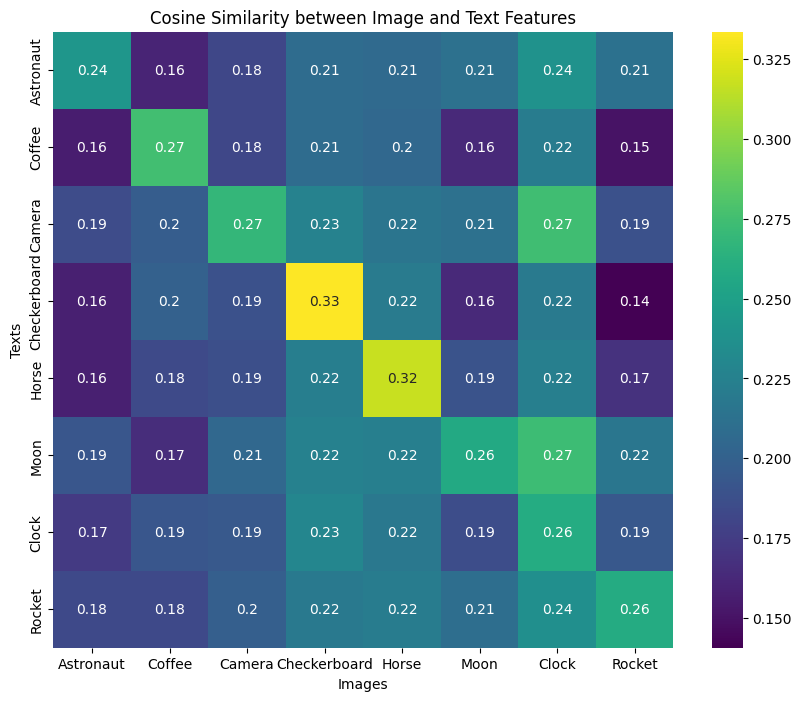

In [18]:
# Normalize the feature vectors
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute the cosine similarity between image and text features
similarity_matrix = text_features @ image_features.T

# Convert similarity matrix to numpy array for visualization
similarity_matrix = similarity_matrix.cpu().numpy()

# Display the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=text_descriptions, yticklabels=text_descriptions, annot=True, cmap='viridis')
plt.title("Cosine Similarity between Image and Text Features")
plt.xlabel("Images")
plt.ylabel("Texts")
plt.show()

## Task 5: Zero-Shot Classification on CIFAR-100

1. Create text descriptions for each class in CIFAR-100 and encode it using
CLIP model.


In [19]:
from torchvision.datasets import CIFAR100

# Load CIFAR-100 class names
cifar100_dataset = CIFAR100(root='./data', download=True)
cifar100_classes = cifar100_dataset.classes

100%|██████████| 169001437/169001437 [00:02<00:00, 63325487.21it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [20]:
# Create text descriptions for CIFAR-100 classes
text_descriptions = [f"a photo of a {label}" for label in cifar100_classes]

# Encode the text descriptions using the CLIP model
text_tokens = clip.tokenize(text_descriptions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)

# Normalize the text feature vectors
text_features /= text_features.norm(dim=-1, keepdim=True)

2. Compute the probability of each CIFAR-100 class for the preprocessed skimage’s images using the CLIP model and display the top matches.

In [22]:
import numpy as np

# Compute the cosine similarity between image and text features
similarity_matrix = text_features @ image_features.T

# Convert cosine similarities to probabilities using softmax
similarity_matrix = similarity_matrix.cpu().numpy()
probabilities = np.exp(similarity_matrix) / np.exp(similarity_matrix).sum(axis=0)

# Display the top matches for each skimage image
top_k = 5
for i, (description, image) in enumerate(images):
    # Get the top k indices for the current image
    top_k_indices = probabilities[:, i].argsort()[-top_k:][::-1]
    top_k_classes = [cifar100_classes[idx] for idx in top_k_indices]
    top_k_probs = probabilities[top_k_indices, i]

    print(f"Top {top_k} matches for '{description}':")
    for class_name, prob in zip(top_k_classes, top_k_probs):
        print(f"  {class_name}: {prob:.4f}")
    print()

Top 5 matches for 'Astronaut':
  woman: 0.0109
  girl: 0.0106
  rocket: 0.0104
  plain: 0.0104
  baby: 0.0104

Top 5 matches for 'Coffee':
  cup: 0.0110
  plate: 0.0106
  bowl: 0.0106
  table: 0.0105
  plain: 0.0104

Top 5 matches for 'Camera':
  man: 0.0106
  boy: 0.0105
  plain: 0.0104
  woman: 0.0103
  telephone: 0.0103

Top 5 matches for 'Checkerboard':
  plain: 0.0104
  plate: 0.0104
  snake: 0.0103
  cup: 0.0103
  can: 0.0103

Top 5 matches for 'Horse':
  cattle: 0.0106
  plain: 0.0106
  camel: 0.0104
  wolf: 0.0104
  dinosaur: 0.0103

Top 5 matches for 'Moon':
  plain: 0.0107
  plate: 0.0105
  rocket: 0.0105
  mountain: 0.0104
  dinosaur: 0.0104

Top 5 matches for 'Clock':
  lamp: 0.0105
  plain: 0.0104
  can: 0.0104
  plate: 0.0104
  clock: 0.0104

Top 5 matches for 'Rocket':
  rocket: 0.0112
  skyscraper: 0.0104
  bridge: 0.0104
  clock: 0.0103
  plain: 0.0103

